<div align="center"> 
    <hr>
  <font size="6"><b>Dev | Clean-Clean Entity Resolution Notebook</b> </font>
   <hr>
</div>

In [18]:
!python --version

Python 3.10.9


In [19]:
import os
import sys
import pandas as pd
import networkx
from networkx import draw, Graph
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from pyjedai.utils import (
    text_cleaning_method,
    print_clusters,
    print_blocks,
    print_candidate_pairs
)
from pyjedai.evaluation import Evaluation, write
from pyjedai.datamodel import Data
d1 = pd.read_csv("./data/ccer/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str)
d2 = pd.read_csv("./data/ccer/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str)
gt = pd.read_csv("./data/ccer/D2/gt.csv", sep='|', engine='python')

data = Data(
    dataset_1=d1,
    attributes_1=['id','name','description'],
    id_column_name_1='id',
    dataset_2=d2,
    attributes_2=['id','name','description'],
    id_column_name_2='id',
    ground_truth=gt,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Block Building

In [20]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    ExtendedQGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking,
)

In [21]:
qgb = QGramsBlocking(qgrams=6)
blocks = qgb.build_blocks(data, attributes_1=['name'], attributes_2=['name'])

Q-Grams Blocking:   0%|          | 0/2152 [00:00<?, ?it/s]

In [22]:
qgb.evaluate(blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Q-Grams Blocking
***************************************************************************************************************************
Method name: Q-Grams Blocking
Parameters: 
	Q-Gramms: 6
Runtime: 0.1175 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.32% 
	Recall:        99.91%
	F1-score:       0.63%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1075
	False positives: 337743
	True negatives: 820032
	False negatives: 1
	Total comparisons: 338818
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 0.3172794833804579,
 'Recall %': 99.90706319702602,
 'F1 %': 0.6325501479873138,
 'True Positives': 1075,
 'False Positives': 337743,
 'True Negatives': 820032,
 'False Negatives': 1}

# Block Cleaning

In [23]:
from pyjedai.block_cleaning import BlockFiltering

In [24]:
bf = BlockFiltering(ratio=0.8)
filtered_blocks = bf.process(blocks, data, tqdm_disable=False)

Block Filtering:   0%|          | 0/3 [00:00<?, ?it/s]

# Comparison Cleaning


In [25]:
from pyjedai.block_cleaning import BlockPurging

In [26]:
cbbp = BlockPurging()
cleaned_blocks = cbbp.process(filtered_blocks, data, tqdm_disable=False)

Block Purging:   0%|          | 0/4924 [00:00<?, ?it/s]

In [27]:
cbbp.evaluate(cleaned_blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Block Purging
***************************************************************************************************************************
Method name: Block Purging
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 3780.0
Runtime: 0.0366 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.83% 
	Recall:        98.51%
	F1-score:       1.65%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1060
	False positives: 126046
	True negatives: 1031714
	False negatives: 16
	Total comparisons: 127106
──────────────────────────────────────────────────────────────────────────────────────────

{'Precision %': 0.8339496168552232,
 'Recall %': 98.51301115241635,
 'F1 %': 1.6538983632647326,
 'True Positives': 1060,
 'False Positives': 126046,
 'True Negatives': 1031714,
 'False Negatives': 16}

## Meta Blocking

In [11]:
from pyjedai.comparison_cleaning import (
    WeightedEdgePruning,
    WeightedNodePruning,
    CardinalityEdgePruning,
    CardinalityNodePruning,
    BLAST,
    ReciprocalCardinalityNodePruning,
    ReciprocalWeightedNodePruning,
    ComparisonPropagation
)

In [12]:
wep = CardinalityEdgePruning(weighting_scheme='X2')
candidate_pairs_blocks = wep.process(filtered_blocks, data)

Cardinality Edge Pruning:   0%|          | 0/1076 [00:00<?, ?it/s]

In [13]:
wep.evaluate(candidate_pairs_blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Cardinality Edge Pruning
***************************************************************************************************************************
Method name: Cardinality Edge Pruning
Parameters: 
	Node centric: False
	Weighting scheme: X2
Runtime: 2.4667 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      9.47% 
	Recall:        89.59%
	F1-score:      17.13%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 964
	False positives: 9215
	True negatives: 1148449
	False negatives: 112
	Total comparisons: 10179
────────────────────────────────────────────────────────────────────────────────────────

{'Precision %': 9.470478435995677,
 'Recall %': 89.59107806691449,
 'F1 %': 17.130164371390492,
 'True Positives': 964,
 'False Positives': 9215,
 'True Negatives': 1148449,
 'False Negatives': 112}

# Entity Matching

It compares pairs of entity profiles, associating every pair with a similarity in [0,1]. Its output comprises the similarity graph, i.e., an undirected, weighted graph where the nodes correspond to entities and the edges connect pairs of compared entities.

In [11]:
from pyjedai.matching import EntityMatching

In [12]:
EM = EntityMatching(
    metric='dice',
    similarity_threshold=0.4,
    attributes = ['description', 'name']
)

pairs_graph = EM.predict(candidate_pairs_blocks, data, tqdm_disable=True)

NameError: name 'candidate_pairs_blocks' is not defined

In [16]:
EM.evaluate(pairs_graph)

***************************************************************************************************************************
                                         Μethod:  Entity Matching
***************************************************************************************************************************
Method name: Entity Matching
Parameters: 
	Tokenizer: white_space_tokenizer
	Metric: dice
	Similarity Threshold: 0.4
Runtime: 1.2030 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     69.50% 
	Recall:        20.54%
	F1-score:      31.71%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 69.49685534591194,
 'Recall %': 20.53903345724907,
 'F1 %': 31.70731707317073,
 'True Positives': 221,
 'False Positives': 97,
 'True Negatives': 1156824,
 'False Negatives': 855}

# Progressive Entity Matching

Applies Entity Matching to a subset of candidate pairs based on prioritization scheme.

In [28]:
from pyjedai.prioritization import (
    GlobalTopPM,
    LocalTopPM,
    EmbeddingsNNBPM
)

In [29]:
LTPM = LocalTopPM(
    budget = 20000,
    w_scheme = 'X2',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

ltpm_pairs_graph = LTPM.predict(filtered_blocks, data, tqdm_disable=True)

In [30]:
GTPM = GlobalTopPM(
    budget = 20000,
    w_scheme = 'X2',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

gtpm_pairs_graph = GTPM.predict(filtered_blocks, data, tqdm_disable=True)

In [20]:
ENNBPM = EmbeddingsNNBPM(
    budget = 20000,
    vectorizer = 'roberta',
    similarity_search = 'faiss',
    emission= 'avg',
    metric = 'dice',
    tokenizer = 'white_space_tokenizer',
    similarity_threshold = 0.1
)
ennbpm_pairs_graph = ENNBPM.predict(candidate_pairs_blocks, data, wep, tqdm_disable=True)

Device selected:  cpu
Vector size:  (1058, 768)
Vectors-1 entering FAISS (1058, 768)
Train FAISS with  (1058, 768)
Indices returned:  (1058, 10)


In [31]:
methods_prediction_data = []
methods_prediction_data.append(("Local Top", list(ltpm_pairs_graph.edges)))
methods_prediction_data.append(("Global Top", list(gtpm_pairs_graph.edges)))
# methods_prediction_data.append(("Embedding BNN", list(ennbpm_pairs_graph)))

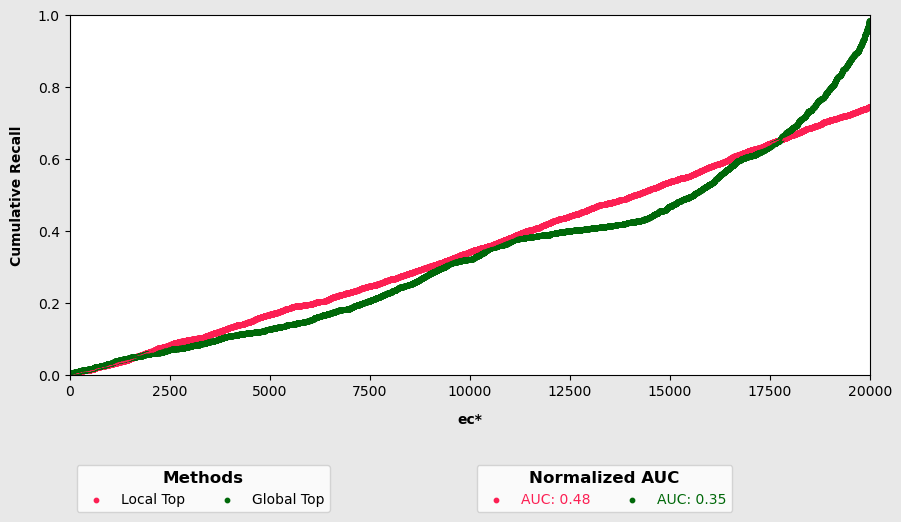

In [32]:
GTPM.evaluate_auc_roc(methods_prediction_data = methods_prediction_data, proportional = False)

In [34]:
ltpm_pairs_graph

# Entity Clustering

It takes as input the similarity graph produced by Entity Matching and partitions it into a set of equivalence clusters, with every cluster corresponding to a distinct real-world object.

In [ ]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering

In [ ]:
ccc = ConnectedComponentsClustering()
clusters = ccc.process(pairs_graph, data)

In [ ]:
ccc.evaluate(clusters, with_classification_report=True)

In [ ]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering
umc = UniqueMappingClustering()
clusters = umc.process(pairs_graph, data)

In [ ]:
umc.evaluate(clusters, with_classification_report=True)